In [1]:
import glob
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from natsort import natsorted
from scipy.stats import describe
from scipy.signal import filtfilt
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
import matplotlib

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', size=12) 
%config InlineBackend.figure_format = 'svg'

In [2]:
path = '/Users/patrick/Documents/phd/GitHub/tikhonov/'

In [3]:
g4iso_files = natsorted(glob.glob(path+"g4out/*KE_*_iso.csv"))

def cnum(xbinw,ebinw):
    R = []
    D = []

    for i in range(5,len(g4iso_files),ebinw): # 100 keV to 1 MeV energy range in steps of 100 keV
        R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:2000:xbinw,3]/5000000.0)
    R = np.transpose(np.array(R))
    RR = R

    return(np.linalg.cond(R))

In [4]:
g4iso_files = natsorted(glob.glob(path+"g4out/*KE_*_iso.csv"))
R = []
D = []

for i in range(5,len(g4iso_files)-101,10): # 100 keV to 1 MeV energy range in steps of 100 keV
    R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:400:1,3]/5000000.0)
R = np.transpose(np.array(R))
RR = R
for j in range(0,370): # X-ray spectra from 0 to 600 keV
    if (np.linalg.norm(R[j,:] > 0)):
        D.append((1.0/np.linalg.norm(R[j,:]))) # Diagonal scaling as a left pre-conditioner
    else:
        D.append(1)

DD = np.diag(D)
RT = np.matmul(DD,R)

S = []
for k in range(0,R.shape[1]):
    #S.append(1.0/(k+1)**2) # right pre-conditioner towards an exponential
    S.append(1.0/np.sum(R[:,k]))
    #S.append(alexa_model_exp[k])
    #S.append(1)
SS = np.diag(S)
RS = np.matmul(RT,SS)

print('response condition number: ' + str(np.linalg.cond(R)))
print('response condition number after preconditioning: ' + str(np.linalg.cond(RS)))

elow_keV = 50
ehigh_keV = 1000
xspace_estep_keV = 1
espace_estep_keV = 10

espace = np.linspace(elow_keV,ehigh_keV,R.shape[1])
xspace = np.linspace(30,400,R.shape[0])

response condition number: 2859.328453484066
response condition number after preconditioning: 44.79055802548671


In [5]:
# generate synthetic data 

e0 = np.linspace(30, 299, R.shape[0])
e1 = np.linspace(100, ehigh_keV, R.shape[1])

def bg(total):
    beam = np.full(len(espace), 0)
    signal = np.full(len(xspace), 0)
    for e in range(0, e0.shape[0]): # normally distributed noise
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(total/len(espace))))
    return((signal,beam))

def ex(fold, elow, ehigh, total):
    beam = np.exp(-e1/fold)
    beam[0:(np.abs(e1 - elow)).argmin()] = 0.0
    beam[(np.abs(e1 - ehigh)).argmin():-1] = 0.0
    integral = np.trapz(beam,e1)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    
    signal = np.matmul(R,beam)
    
    for e in range(0, e0.shape[0]):
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(signal[e])))
        
    return(signal,beam)

def gauss(mu, sig, elow, ehigh, total):
    beam = total*np.exp(-np.power(e1 - mu, 2.) / (2 * np.power(sig, 2.)))
    beam[0:(np.abs(e1 - elow)).argmin()] = 0.0 # low and high energy cutoffs
    beam[(np.abs(e1 - ehigh)).argmin():-1] = 0.0
    integral = np.trapz(beam, x=e1)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    signal = np.matmul(R,beam)
    for e in range(0, e0.shape[0]): 
        signal[e] = np.random.normal(signal[e], scale=np.sqrt(signal[e]))
    return(signal,beam)

def mono(e, total):
    beam = np.full(e1.shape[0], 0.0)
    beam[(np.abs(e1 - e)).argmin()] = total
    signal = np.matmul(R,beam) # beam should integrate to total e-/cm^2/s
    for e in range(0, e0.shape[0]): 
        signal[e] = np.random.normal(signal[e], scale=np.sqrt(signal[e]))
    return((signal,beam))

In [6]:
beam0 = ex(100,0,1000,1e8)
np.savetxt('beam_ex_100_0_1000_1e10_4.out', beam0[0], delimiter=',') 
np.savetxt('beam_ex_100_0_1000_1e10_5.out', beam0[1], delimiter=',') 
np.savetxt('xspace_2',xspace,delimiter=',')
np.savetxt('espace_2',espace,delimiter=',')
np.savetxt('R2',R,delimiter=',')

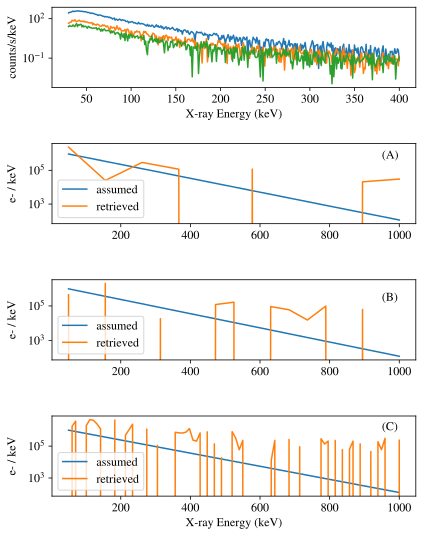

In [22]:
beam00 = np.loadtxt('beam_ex_100_0_1000_1e10_0.out')
beam01 = np.loadtxt('beam_ex_100_0_1000_1e10_1.out')

beam10 = np.loadtxt('beam_ex_100_0_1000_1e10_2.out')
beam11 = np.loadtxt('beam_ex_100_0_1000_1e10_3.out')

beam20 = np.loadtxt('beam_ex_100_0_1000_1e10_4.out')
beam21 = np.loadtxt('beam_ex_100_0_1000_1e10_5.out')


xspace0 = np.loadtxt('xspace_0')
espace0 = np.loadtxt('espace_0')

xspace1 = np.loadtxt('xspace_1')
espace1 = np.loadtxt('espace_1')

xspace2 = np.loadtxt('xspace_2')
espace2 = np.loadtxt('espace_2')

R0 = np.loadtxt('R0',delimiter=',')
R1 = np.loadtxt('R1',delimiter=',')
R2 = np.loadtxt('R2',delimiter=',')

fig = plt.figure(figsize=(6.52437527778,9))
gs = plt.GridSpec(nrows=4, ncols=1,hspace=.7,wspace=.3)


ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax4 = fig.add_subplot(gs[2])
ax6 = fig.add_subplot(gs[3])

ax1.semilogy(xspace0,beam00)
ax1.semilogy(xspace0,beam10)
ax1.semilogy(xspace0,beam20)


ax2.semilogy(espace2,beam21, label='assumed')
ax2.semilogy(espace2,np.matmul(np.linalg.pinv(R2),beam20)/2.0,label='retrieved')

ax4.semilogy(espace1,beam11, label='assumed')
ax4.semilogy(espace1,np.matmul(np.linalg.pinv(R1),beam10)/2,label='retrieved')

ax6.semilogy(espace0,beam01,label='assumed')
ax6.semilogy(espace0,np.matmul(np.linalg.pinv(R0),beam00)/2,label='retrieved')

ax1.set_ylabel('counts/s/keV')
ax1.set_xlabel('X-ray Energy (keV)')
ax6.set_xlabel('X-ray Energy (keV)')

ax2.set_ylabel('e- / keV',labelpad=10)
ax4.set_ylabel('e- / keV',labelpad=10)
ax6.set_ylabel('e- / keV',labelpad=10)

ax2.legend()
ax4.legend()
ax6.legend()

ax2.text(950,0.5e6,"(A)")
ax4.text(950,0.2e6,"(B)")
ax6.text(950,1e6,"(C)")

plt.savefig('direct_inversion_example.pdf')  
plt.show()


In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import datetime
import glob
from natsort import natsorted
from io import BytesIO
from scipy.optimize import nnls
from IPython.display import clear_output
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm


plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', size=24)
%matplotlib inline


In [88]:
# note - if you change settings - beam type, spectrum bin widths, etc, you will need to adjust the plot labels. 
# the value for alphja from the L-curve method, for example, is set by visually looking at that graph. 
# they do not update automatically.

beam_type = 'iso' # use isotropic beam, other options are 'cos' for lambertian or 'beam1d' for pencil beam

# x-ray spectrum discretization. min is 30 keV, max is 1000 keV, min step is 10 keV
x_low_keV =  30   # around 30 keV works well and captures the low energy inflection point;
x_high_keV = 500  # should be left at around 500 keV, X-ray spectra do not usually extend farther
x_bin_keV =  10    # should be left at 1 keV. There is no benefit to coarser binning here and it makes the condition number worse.

# electron spectrum discretization. min is 70 keV, max is 2000 keV, min step is 10 keV
e_low_keV =  100    # suggest 100 keV
e_high_keV = 500  # should be set to the lowest value you expect from your X-ray data
e_bin_keV =  50    # minimum 10 keV, step size is 10 keV. 

g4_response_data = np.load('/Users/patrick/Documents/phd/data/g4_response.zip')
response = []
file_names = []

# assemble the matrix which maps electron spectra to X-ray spectra by matrix multiplication
for file in natsorted(g4_response_data.files): # arranged by energy
  if (beam_type in file):                      # use the chosen beam type (iso, cos, or beam1d)
    file_names.append(file)
for i in range(int(e_low_keV/10), int((e_high_keV+10)/10), int(e_bin_keV/10)): # energies are sampled in multiples of 10 keV
  response.append(np.loadtxt(BytesIO(g4_response_data[file_names[i]]), dtype='float', delimiter=',', skiprows=9)[x_low_keV:x_high_keV:x_bin_keV,3]/5000000.0)
response = np.array(response).T

# make ranges for X-ray and electron spectrum energies
xspace = np.linspace(x_low_keV,x_high_keV,response.shape[0])
espace = np.linspace(e_low_keV,e_high_keV,response.shape[1])

#  implement tikhonov regularization of different orders with optional non-negativity constraint and preconditioner
def tk(r, alpha, x, order, leftprecon, rightprecon, nneg):
  
  right = []
  for i in range(0, r.shape[1]):
    norm = np.linalg.norm(r[:,i])
    if (norm > 0):
      right.append(1.0/np.linalg.norm(r[:,i]))
    else: 
      right.append(1.0)
  right = np.diag(np.array(right))

  left = []
  for i in range(0, r.shape[0]):
    norm = np.linalg.norm(r[i,:])
    if (norm > 0):
      left.append(1.0/np.linalg.norm(r[i,:]))
    else: 
      left.append(1.0)
  left = np.diag(np.array(left))

  if (not leftprecon):
    left = np.identity(r.shape[0])
  if (not rightprecon):
    right = np.identity(r.shape[1])

  x = np.matmul(left, x)
  R = np.matmul(left,np.matmul(r, right))
  I = np.identity(R.shape[1])          # use for zeroth-order
  L1 = np.copy(I) 
  for i in range(0, R.shape[1] - 1):   # use for first-order
    L1[i,i+1] = -1.0
  L2 = np.copy(I) 
  for i in range(1, R.shape[1]-1):     # use for second-order
    L2[i,i] = -2.0
    L2[i,i+1] = 1.0 
    L2[i,i-1] = 1.0
  L2[0,0] = -2
  L2[0,1] = 1
  L2[-1,-2] = -1
  L2[-1,-1] = -2
  if (order == None):
    op = I*0.0
  elif (order == 0):
    op = I
  elif (order == 1):
    op = L1
  elif (order == 2):
    op = L2
  else:
    return(-1)
  C = np.matmul(np.transpose(R),R) + (alpha**2)*np.matmul(np.transpose(op),op) # normal equations provide explicit solution
  D = np.matmul(np.transpose(R), x)

  if (nneg):
    sol = np.matmul(nnls(C,D,maxiter=10**18)[0],right)      # solve using non-negative least-squares
  else:
    sol = np.matmul(np.linalg.solve(C,D),right)

  error = np.linalg.norm(np.matmul(R,sol) - x)            # difference between the regularized solution and the least-squares solution
  penalty = np.linalg.norm(sol)                           # in zeroth-order tikhonov, the penalty is the norm of the solution
  return(sol,error,penalty)                               # keep track of the error and penalty terms 

# apply leave-one-out cross validation to choose alpha. We choose the alpha that minimizes the error term when x-ray data points are suppressed. 
def cv(r, alphas, x, order, rightprecon, leftprecon, nneg):
    err = []
    for alpha in alphas:
        e = 0
        for i in range(0, len(x)-1,20):                            # this is expensive
            response_truncated = np.delete(response,i,0)       
            x_truncated = np.delete(x,i)                        # delete one X-ray data point and solve the reduced problem
            sol = tk(response_truncated, alpha, x_truncated, order, rightprecon, leftprecon, nneg)[0]
            sol[-1] = 0.0
            e += (np.matmul(response,sol)[i] - x[i])**2 # add the error between the resulting solution and the missing data point
        err.append(e)                                             # this value of alpha gave this total error between fit models and suppressed data points
    return(err) 

In [89]:
def ex(fold, total):
    beam = np.exp(-espace/fold)

    integral = np.trapz(beam,espace)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    
    signal = np.matmul(response,beam)
    
    for e in range(0, xspace.shape[0]):
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(signal[e])))
    return([beam,signal])

def mono(e, total):
    beam = np.full(espace.shape[0], 0.0)
    beam[(np.abs(espace - e)).argmin()] = total
    signal = np.matmul(response,beam) # beam should integrate to total e-/cm^2/s
    return([beam,signal])

In [90]:
ee = ex(313,1e6)
em = mono(313,1e6)

In [194]:
e0  = ex(300,1e9)
e1 = ex(300,1e8)
e2 = ex(300,1e7)

ee = ex(300,3e10) 
ec = np.sum(e0[1])/np.sum(ee[1])
ecx = np.sum(e0[0])/np.sum(ee[0])

eee = ex(300,1e10)
eeec = np.sum(ee[0])/np.sum(eee[0])
eeecx = np.sum(ee[1])/np.sum(eee[1])

plt.rcParams['text.usetex'] = True

/var/folders/95/2gtjccms72s2v7wsktz_j2r80000gn/T/ipykernel_47021/243539633.py:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_ylim(0,1e8)


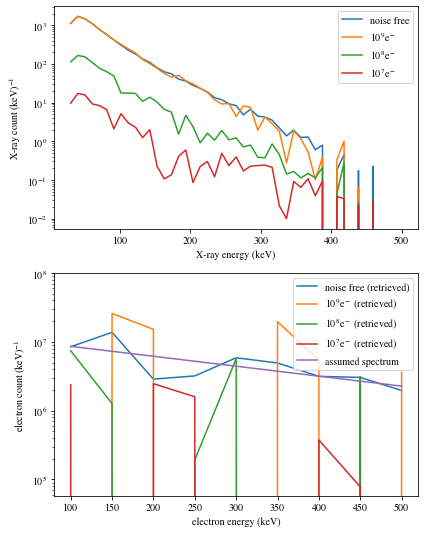

In [199]:
fig = plt.figure(figsize=(6.52437527778,9))
gs = plt.GridSpec(nrows=2, ncols=1,hspace=.2,wspace=.3)


ax1 = fig.add_subplot(gs[0])
ax1.semilogy(xspace,ee[1]*ec, label='noise free')
ax1.semilogy(xspace,e0[1], label='$10^{9} \mathrm{e}^-$')
ax1.semilogy(xspace,e1[1], label='$10^{8} \mathrm{e}^-$')
ax1.semilogy(xspace,e2[1], label='$10^{7} \mathrm{e}^-$')
ax1.set_xlabel('X-ray energy (keV)')
ax1.set_ylabel('X-ray count $\mathrm{(keV)}^{-1}$')
ax1.legend()

ax2 = fig.add_subplot(gs[1])
ax2.semilogy(espace,np.matmul(np.linalg.pinv(response),ee[1])*ecx, label='noise free (retrieved)')
ax2.semilogy(espace,np.matmul(np.linalg.pinv(response),e0[1]), label='$10^{9} \mathrm{e}^-$ (retrieved)')
ax2.semilogy(espace,np.matmul(np.linalg.pinv(response),e1[1]), label='$10^{8} \mathrm{e}^-$ (retrieved)')
ax2.semilogy(espace,np.matmul(np.linalg.pinv(response),e2[1]), label='$10^{7} \mathrm{e}^-$ (retrieved)')
ax2.semilogy(espace,eee[0]*eeec*ec*1.9,label='assumed spectrum')

ax2.set_xlabel('electron energy (keV)')
ax2.set_ylabel('electron count $\mathrm{(keV)}^{-1}$')
ax2.set_ylim(0,1e8)
ax2.legend()


plt.savefig('direct_inversion_example.pdf')  
